# Redes neuronales

En este notebook clasificaremos si una instancia tiene alto poder adquisitivo mediante redes neuronales.

Se utilizarán dos preprocessings diferentes:

* PCA con el 75% de la varianza explicada

* Preprocessing primera parte

* Preprocessing mejores features de un árbol

In [63]:
# Red neuronal
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import Model

# Otros
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import utils
from preprocessing import preprocessing_significantes
from preprocessing import preprocessing_base_parte_1

# Metricas
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report

In [2]:
df = utils.get_data()

## Modelo 1 - Significantes 75% varianza

In [3]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=27)

X_train_1, X_test_1 = preprocessing_significantes(X_train_1, X_test_1, variance=0.75)

/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test['ganancia_perdida_declarada_bolsa_argentina'].apply(

In [68]:
import tensorflow_model_optimization as tfmot

In [125]:
n_in = X_train_1.shape[1]

m = Sequential([
  InputLayer(input_shape=n_in),
  Dense(52, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0001),
                                   activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Dropout(0.5),
  Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0001),
                                   activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Dropout(0.4),
  Dense(15, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0001),
                                   activity_regularizer=tf.keras.regularizers.l2(0.01)),  
  Dropout(1/15),
  Dense(1, activation='sigmoid')
])

In [126]:
m.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC()])

In [127]:
m.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 52)                2756      
_________________________________________________________________
dropout_32 (Dropout)         (None, 52)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 30)                1590      
_________________________________________________________________
dropout_33 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 15)                465       
_________________________________________________________________
dropout_34 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)               

In [118]:
h = m.fit(X_train_1, y_train_1, epochs=200, batch_size=10, verbose=4, validation_split=0.3)

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

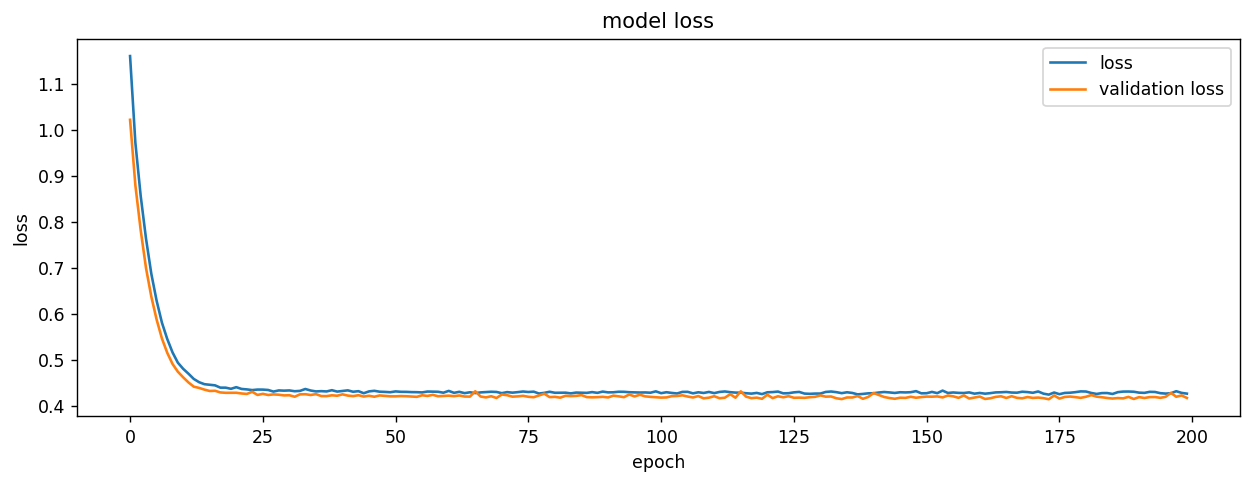

In [119]:
plt.figure(dpi=125, figsize=(12, 4))
plt.plot(h.history['loss'], label="loss")
plt.plot(h.history['val_loss'], label="validation loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

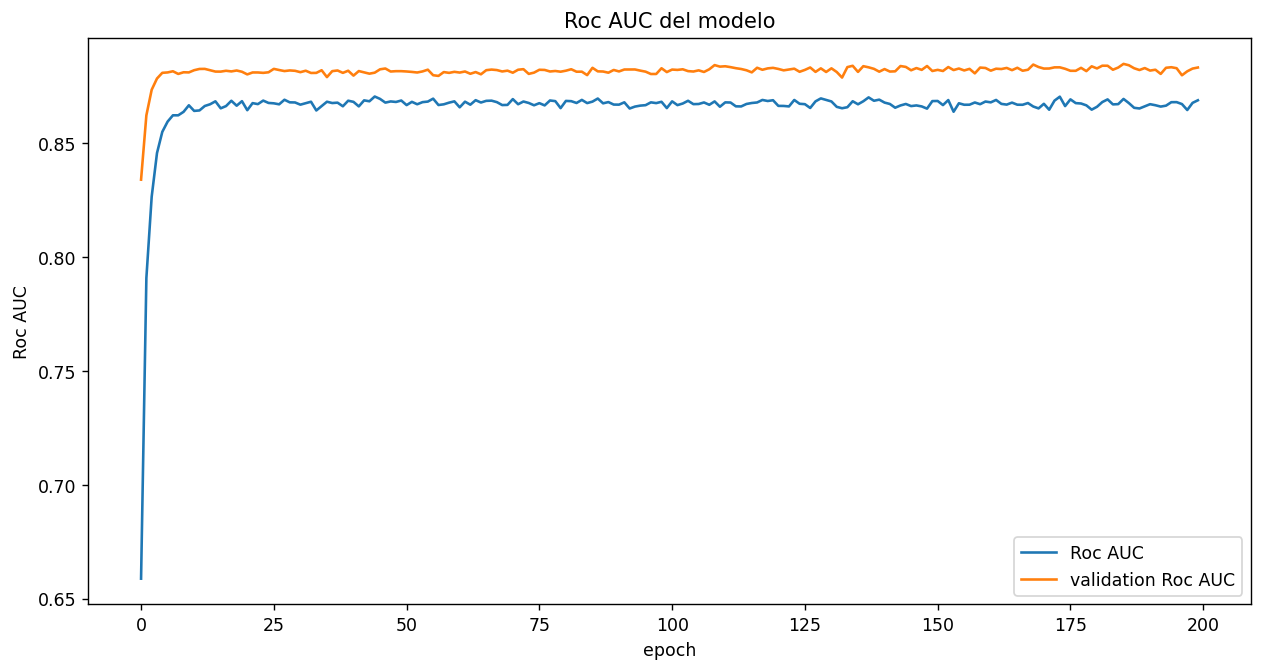

In [121]:
plt.figure(dpi=125, figsize=(12, 6))
plt.plot(h.history['auc_10'], label="Roc AUC")
plt.plot(h.history['val_auc_10'], label="validation Roc AUC")
plt.title('Roc AUC del modelo')
plt.ylabel('Roc AUC')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [122]:
print(classification_report(y_test_1, h.model.predict(X_test_1, verbose=4) > 0.5))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6186
           1       0.71      0.54      0.61      1955

    accuracy                           0.84      8141
   macro avg       0.79      0.74      0.76      8141
weighted avg       0.83      0.84      0.83      8141



In [99]:
from sklearn.metrics import roc_auc_score

In [123]:
roc_auc_score(y_test_1, h.model.predict(X_test_1))

0.8896745228686507